In [1]:
!pip install omegaconf einops pytorch_lightning
!pip install opencv-python timm
!git clone https://github.com/Stability-AI/stablediffusion
!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt
!wget https://huggingface.co/stabilityai/stable-diffusion-2-depth/resolve/main/512-depth-ema.ckpt
!mkdir midas_models
!mv dpt_hybrid-midas-501f0c75.pt midas_models/dpt_hybrid-midas-501f0c75.pt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import pathlib
import sys
sys.path.append(str((pathlib.Path(".") / "stablediffusion").absolute()))
with open(pathlib.Path(".") / "stablediffusion" / "ldm" / "__init__.py", "w") as f:
    f.write("")

import ldm

In [2]:
import sys
import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from einops import repeat, rearrange
from pytorch_lightning import seed_everything

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.data.util import AddMiDaS

torch.set_grad_enabled(False)



2022-12-17 22:25:50.417768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 22:25:51.027704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda-11.4/extras/Debugger/lib64:/usr/local/cuda-11.4/extras/Debugger/include
2022-12-17 22:25:51.027758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

In [3]:
def initialize_model(config, ckpt):
    config = OmegaConf.load(config)
    model = instantiate_from_config(config.model)
    model.load_state_dict(torch.load(str(ckpt.absolute()))["state_dict"], strict=False)

    device = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)
    sampler = DDIMSampler(model)
    return sampler
sampler = initialize_model(pathlib.Path(".") / "stablediffusion" / "configs" / "stable-diffusion" / "v2-midas-inference.yaml",
                           pathlib.Path(".")  / "512-depth-ema.ckpt")

No module 'xformers'. Proceeding without it.
LatentDepth2ImageDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/pawel/projekty/aiart/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [4]:
def pad_image(input_image):
    pad_w, pad_h = np.max(((2, 2), np.ceil(
        np.array(input_image.size) / 64).astype(int)), axis=0) * 64 - input_image.size
    im_padded = Image.fromarray(
        np.pad(np.array(input_image), ((0, pad_h), (0, pad_w), (0, 0)), mode='edge'))
    return im_padded


def make_batch_sd(
        image,
        txt,
        device,
        num_samples=1,
        model_type="dpt_hybrid"
):
    image = np.array(image.convert("RGB"))
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
    # sample['jpg'] is tensor hwc in [-1, 1] at this point
    midas_trafo = AddMiDaS(model_type=model_type)
    batch = {
        "jpg": image,
        "txt": num_samples * [txt],
    }
    batch = midas_trafo(batch)
    batch["jpg"] = rearrange(batch["jpg"], 'h w c -> 1 c h w')
    batch["jpg"] = repeat(batch["jpg"].to(device=device),
                          "1 ... -> n ...", n=num_samples)
    batch["midas_in"] = repeat(torch.from_numpy(batch["midas_in"][None, ...]).to(
        device=device), "1 ... -> n ...", n=num_samples)
    return batch

def paint(sampler, image, prompt, t_enc, seed, scale, num_samples=1, callback=None,
          do_full_sample=False):
    device = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = sampler.model
    seed_everything(seed)

    with torch.no_grad(),\
            torch.autocast("cuda"):
        batch = make_batch_sd(
            image, txt=prompt, device=device, num_samples=num_samples)
        z = model.get_first_stage_encoding(model.encode_first_stage(
            batch[model.first_stage_key]))  # move to latent space
        c = model.cond_stage_model.encode(batch["txt"])
        c_cat = list()
        for ck in model.concat_keys:
            cc = batch[ck]
            cc = model.depth_model(cc)
            depth_min, depth_max = torch.amin(cc, dim=[1, 2, 3], keepdim=True), torch.amax(cc, dim=[1, 2, 3],
                                                                                           keepdim=True)
            display_depth = (cc - depth_min) / (depth_max - depth_min)
            depth_image = Image.fromarray(
                (display_depth[0, 0, ...].cpu().numpy() * 255.).astype(np.uint8))
            cc = torch.nn.functional.interpolate(
                cc,
                size=z.shape[2:],
                mode="bicubic",
                align_corners=False,
            )
            depth_min, depth_max = torch.amin(cc, dim=[1, 2, 3], keepdim=True), torch.amax(cc, dim=[1, 2, 3],
                                                                                           keepdim=True)
            cc = 2. * (cc - depth_min) / (depth_max - depth_min) - 1.
            c_cat.append(cc)
        c_cat = torch.cat(c_cat, dim=1)
        # cond
        cond = {"c_concat": [c_cat], "c_crossattn": [c]}

        # uncond cond
        uc_cross = model.get_unconditional_conditioning(num_samples, "")
        uc_full = {"c_concat": [c_cat], "c_crossattn": [uc_cross]}
        if not do_full_sample:
            # encode (scaled latent)
            z_enc = sampler.stochastic_encode(
                z, torch.tensor([t_enc] * num_samples).to(model.device))
        else:
            z_enc = torch.randn_like(z)
        # decode it
        samples = sampler.decode(z_enc, cond, t_enc, unconditional_guidance_scale=scale,
                                 unconditional_conditioning=uc_full, callback=callback)
        x_samples_ddim = model.decode_first_stage(samples)
        result = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
        result = result.cpu().numpy().transpose(0, 2, 3, 1) * 255
    return [depth_image] + [Image.fromarray(img.astype(np.uint8)) for img in result]

def predict(input_image, prompt, steps, num_samples, scale, seed, eta, strength):
    init_image = input_image.convert("RGB")
    image = pad_image(init_image)  # resize to integer multiple of 32

    sampler.make_schedule(steps, ddim_eta=eta, verbose=True)
    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    do_full_sample = strength == 1.
    t_enc = min(int(strength * steps), steps-1)
    result = paint(
        sampler=sampler,
        image=image,
        prompt=prompt,
        t_enc=t_enc,
        seed=seed,
        scale=scale,
        num_samples=num_samples,
        callback=None,
        do_full_sample=do_full_sample
    )
    return result

In [13]:

init_img = Image.open("/home/pawel/git/NeuralNetworksSketchbook/car.jpg").convert("RGB")
init_img_ = init_img.copy()
size = [i/2 for i in init_img.size]  # My GPU is too small :(
init_img_.thumbnail(size, Image.Resampling.LANCZOS)
init_img_
i = 1024

Global seed set to 1037
Decoding image: 100%|██████████| 90/90 [00:03<00:00, 28.13it/s]


Selected timesteps for ddim sampler: [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9895, 0.9804, 0.9708, 0.9609, 0.9505, 0.9398, 0.9287, 0.9171,
        0.9052, 0.8930, 0.8804, 0.8674, 0.8540, 0.8404, 0.8264, 0.8121, 0.7975,
        0.7827, 0.7675, 0.7521, 0.7365, 0.7207, 0.7047, 0.6885, 0.6722, 0.6557,
        0.6391, 0.6224, 0.6056, 0.5888, 0.5720, 0.5551, 0.5383, 0.5215, 0.5048,
        0.4882, 0.4716, 0.4552, 0.4390, 0.4229, 0.4070, 0.3913, 0.3758, 0.3605,
        0.3456, 0.3308, 0.3164, 0.3023, 0.2885, 0.2750, 0.2618, 0.2490, 0.2366,
        0.2245, 0.2128, 0.2014, 0.190

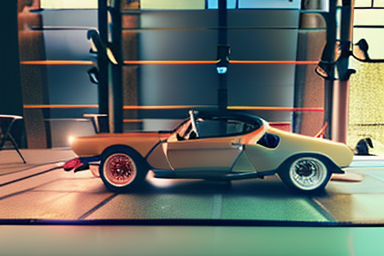

In [59]:
i = 1037
imgs = predict(init_img_, " A photo of a sport car, from the left, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
               100, 1, 9, i, 0.0, 0.9)
imgs[1]

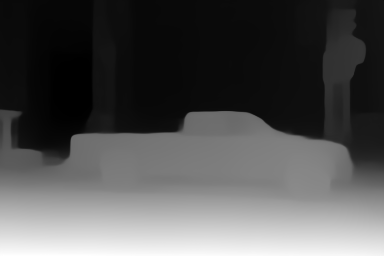

In [7]:
imgs[0]

Global seed set to 1030
Decoding image: 100%|██████████| 25/25 [00:00<00:00, 27.36it/s]


Selected timesteps for ddim sampler: [  1  21  41  61  81 101 121 141 161 181 201 221 241 261 281 301 321 341
 361 381 401 421 441 461 481 501 521 541 561 581 601 621 641 661 681 701
 721 741 761 781 801 821 841 861 881 901 921 941 961 981]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9804, 0.9609, 0.9398, 0.9171, 0.8930, 0.8674, 0.8404, 0.8121,
        0.7827, 0.7521, 0.7207, 0.6885, 0.6557, 0.6224, 0.5888, 0.5551, 0.5215,
        0.4882, 0.4552, 0.4229, 0.3913, 0.3605, 0.3308, 0.3023, 0.2750, 0.2490,
        0.2245, 0.2014, 0.1799, 0.1598, 0.1413, 0.1243, 0.1087, 0.0946, 0.0819,
        0.0705, 0.0604, 0.0514, 0.0435, 0.0365, 0.0305, 0.0254, 0.0210, 0.0172,
        0.0140, 0.0113, 0.0091, 0.0073, 0.0058]); a_(t-1): [0.99914998 0.99829602 0.98038077 0.96087277 0.93978298 0.91713792
 0.89298052 0.86737001 0.84038192 0.81210774 0.78265446 0.75214338
 0.72070938 0.68849909 0.65566933 0.62238538 0.58881873 0.55514455
 0.52153981 0.4881804  0.45523876 0.42288151 0.39126703 0.36

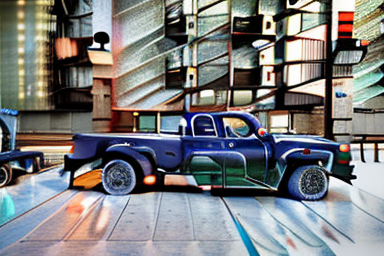

In [37]:
i += 1
imgs = predict(init_img_, " A photo of a gigantic truck, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
               50, 1, 9, i, 0.0, 0.5)
imgs[1]

Global seed set to 1037
Decoding image: 100%|██████████| 90/90 [00:03<00:00, 26.91it/s]


Selected timesteps for ddim sampler: [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9895, 0.9804, 0.9708, 0.9609, 0.9505, 0.9398, 0.9287, 0.9171,
        0.9052, 0.8930, 0.8804, 0.8674, 0.8540, 0.8404, 0.8264, 0.8121, 0.7975,
        0.7827, 0.7675, 0.7521, 0.7365, 0.7207, 0.7047, 0.6885, 0.6722, 0.6557,
        0.6391, 0.6224, 0.6056, 0.5888, 0.5720, 0.5551, 0.5383, 0.5215, 0.5048,
        0.4882, 0.4716, 0.4552, 0.4390, 0.4229, 0.4070, 0.3913, 0.3758, 0.3605,
        0.3456, 0.3308, 0.3164, 0.3023, 0.2885, 0.2750, 0.2618, 0.2490, 0.2366,
        0.2245, 0.2128, 0.2014, 0.190

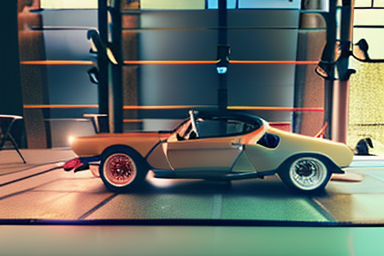

In [99]:

# imgs = predict(init_img_, " A photo of a rusted old truck, 800mm, highly detailed, retro, sharp, Katsuhiro Otomo, long lens,  masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd, professional",
#                50, 1, 9, 2032231, 0.0, 0.8)
imgs = predict(init_img_, "A photo of a sport car, from the left, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
                   100, 1, 9, 1037, 0.0, 0.9)
imgs[1]

In [101]:
clear output by throwing exception.
for i in range(100):
    imgs = predict(init_img_, "A photo of a sport car, from the left, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
                   100, 1, 9, 1037, 0.0, i/100)
    imgs[1].save(F"out/sport/{i}_sport_car.png")

    imgs = predict(init_img_, " A photo of a gigantic truck, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
                   100, 1, 9, 2032231, 0.0, i/100)
    imgs[1].save(F"out/truck/{i}_truck.png")

    imgs = predict(init_img_, " A photo of a family truck, highly detailed, retro, unreal engine, masterpiece, trending on artstation, featured on pixiv, cinematic composition, beautiful lighting, sharp, details, highly detailed, uhd",
                   100, 1, 9, i, 0.0, 0.8)
    imgs[1].save(F"out/f/{i}_f.png")

SyntaxError: invalid syntax (2779264962.py, line 1)

In [55]:
i

1037